# Лабораторная работа №3. Краевая задача.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Запишем условия задачи:\
$ y" - P^2(x)y = f(x), \qquad P^2(x) = 10 + sin(2\pi x), \:\: f(x) = cos(2\pi x), t \in [0; 1] $\
Используется разностная схема:\
$ \frac{y_1 - 2y_0 + y_{N - 1}}{h^2} - P^2(0)y_0 = f(0), $\
$ \frac{y_{n + 1} - 2y_n + y_{n - 1}}{h^2} - P^2(nh)y_n = f(nh), \:\: n \in [1, N - 2] \cap \mathbb{N}$\
$ \frac{y_0 - 2y_{N - 1} + y_{N - 2}}{h^2} - P^2(1 - h)y_{N - 1} = f(1 - h), \:\: Nh = 1 $

In [2]:
h = 0.005
N = int(1 / h)
x = np.linspace(0, 1, N)

# Functions P^2(x) and f(x)
def P2(x):
    return 10 + np.sin(2 * np.pi * x)

def f(x):
    return np.cos(2 * np.pi * x)

# Coefficients of the difference scheme
a = np.ones(N) / h**2 
b = - 2 * np.ones(N) / h**2 - P2(x)
c = np.ones(N) / h**2
d = np.zeros(N)  # elements for y_0
e = np.zeros(N)  # elements for y_{N-1}
f_vals = f(x)

Так как имеем систему с циклическими граничными условиями, то будем использовать метод периодической прогонки:
1) Система имеет вид:\
$ a_n y_{n - 1} + n_n y_n + c_n y_{n + 1} + d_n y_0 + e_n y_{N - 1} = f_n, $ где \
$d_n \neq 0, \:\: e_n \neq 0 $ только для $n = 0$ и $N = N - 1$
2) Разделим исходную систему с помощью вспомогательных векторов ($z_n, u_n, v_n$) для решения каждой части обычным методом прогонки (для каждого вспомогательного вектора):\
$ y_n = z_n + u_n y_0 + v_n y_{N - 1}$ 
3) После нахождения $z_n, u_n, v_n$ решаем систему для $y_0, y_{N - 1}$ а затем и для остальных $y_n$ (для $y_0, y_{N - 1}$ решается малая система $2 \times 2$ с матрицей $A_{small}$ и вектором $b_{small}$).


In [3]:
# Set cyclic elements
d[0] = 1 / h**2
e[0] = 0
d[N - 1] = 0
e[N - 1] = 1 / h**2

# Gauss-Zeidel method for 2×2 system
def Zeidel_solver(A, b, epsilon=1e-6, max_iter=1000):
    y = np.zeros(2)  # initial guess [y_0, y_{N-1}]
    for k in range(max_iter):
        y_new = y.copy()

        y_new[0] = (b[0] - A[0][1] * y[1]) / A[0][0]
        y_new[1] = (b[1] - A[1][0] * y_new[0]) / A[1][1]
        
        # Check solution
        if np.max(np.abs(y_new - y)) < epsilon:
            return y_new
        y = y_new
        
    return y

# Periodic tridiagonal solver
def periodic_tridiagonal_solver(a, b, c, d, e, f_vals, N):
    # Step 1: Solve for z (standard tridiagonal solver)
    z = np.zeros(N)
    u = np.zeros(N)
    v = np.zeros(N)

    # Solve for z: a_n z_{n-1} + b_n z_n + c_n z_{n+1} = f_n
    alpha = np.zeros(N)
    beta = np.zeros(N)
    alpha[0] = 0
    beta[0] = 0
    for i in range(1, N-1):
        alpha[i] = - c[i - 1] / (b[i - 1] + a[i - 1] * alpha[i - 1])
        beta[i] = (f_vals[i - 1] - a[i - 1] * beta[i - 1]) / (b[i - 1] + a[i - 1] * alpha[i - 1])
    
    z[N - 1] = 0
    for i in range(N - 2, - 1, - 1):
        z[i] = alpha[i + 1] * z[i + 1] + beta[i + 1]

    # Step 2: Solve for u: a_n u_{n-1} + b_n u_n + c_n u_{n+1} = -d_n
    alpha_u = np.zeros(N)
    beta_u = np.zeros(N)
    alpha_u[0] = 0
    beta_u[0] = 0
    for i in range(1, N - 1):
        alpha_u[i] = - c[i - 1] / (b[i - 1] + a[i - 1] * alpha_u[i - 1])
        beta_u[i] = (- d[i - 1] - a[i - 1] * beta_u[i - 1]) / (b[i - 1] + a[i - 1] * alpha_u[i - 1])
    
    u[N - 1] = 0
    for i in range(N - 2, - 1, - 1):
        u[i] = alpha_u[i + 1] * u[i + 1] + beta_u[i + 1]

    # Step 3: Solve for v: a_n v_{n-1} + b_n v_n + c_n v_{n+1} = -e_n
    alpha_v = np.zeros(N)
    beta_v = np.zeros(N)
    alpha_v[0] = 0
    beta_v[0] = 0
    for i in range(1, N - 1):
        alpha_v[i] = - c[i - 1] / (b[i - 1] + a[i - 1] * alpha_v[i - 1])
        beta_v[i] = (- e[i - 1] - a[i - 1] * beta_v[i - 1]) / (b[i - 1] + a[i - 1] * alpha_v[i - 1])
    
    v[N - 1] = 0
    for i in range(N - 2, - 1, - 1):
        v[i] = alpha_v[i + 1] * v[i + 1] + beta_v[i + 1]

    # Step 4: Solve for y_0 and y_{N-1}
    A_small = np.zeros((2, 2))
    b_small = np.zeros(2)
    
    A_small[0][0] = b[0] + a[0] * u[1] + c[0] * u[N - 1]
    A_small[0][1] = e[0] + a[0] * v[1] + c[0] * v[N - 1]
    A_small[1][0] = d[N - 1] + a[N - 1] * u[N - 2] + c[N - 1] * u[0]
    A_small[1][1] = b[N - 1] + a[N - 1] * v[N - 2] + c[N - 1] * v[0]
    
    b_small[0] = f_vals[0] - (a[0] * z[1] + b[0] * z[0] + c[0] * z[N - 1])
    b_small[1] = f_vals[N - 1] - (a[N - 1] * z[N - 2] + b[N - 1] * z[N - 1] + c[N - 1] * z[0])
    
    y0_yN1 = Zeidel_solver(A_small, b_small)
    y0  = y0_yN1[0]
    yN1 = y0_yN1[1]

    # Step 5: Compute y_n
    y = np.zeros(N)
    for i in range(N):
        y[i] = z[i] + u[i] * y0 + v[i] * yN1

    return y

Промежуточные значения в узлах сетки (каждое 20-е):
x = 0.000, y = -0.000302
x = 0.101, y = -0.001331
x = 0.201, y = 0.005377
x = 0.302, y = 0.015640
x = 0.402, y = 0.024517
x = 0.503, y = 0.028033
x = 0.603, y = 0.024618
x = 0.704, y = 0.015766
x = 0.804, y = 0.005551
x = 0.905, y = -0.000913


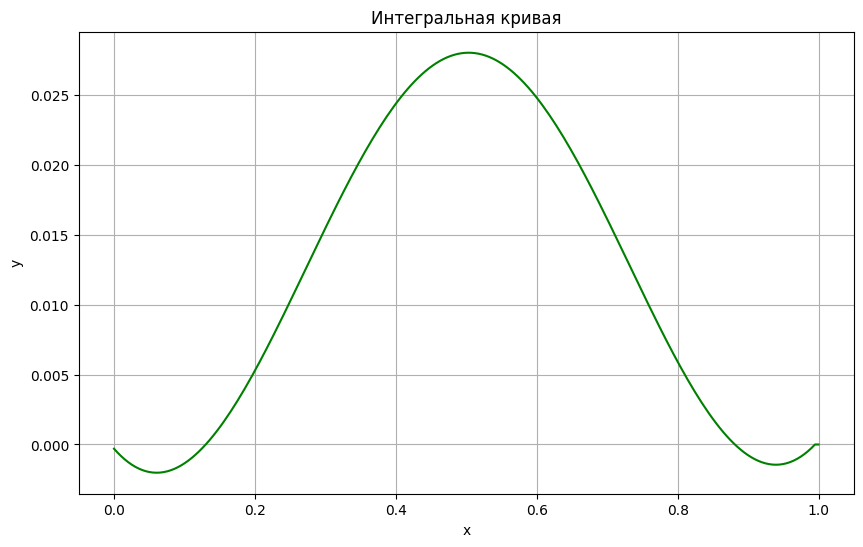

In [4]:
y = periodic_tridiagonal_solver(a, b, c, d, e, f_vals, N)

print("Промежуточные значения в узлах сетки (каждое 20-е):")
for i in range(0, N, 20):
    print(f"x = {x[i]:.3f}, y = {y[i]:.6f}")

fig = plt.figure(figsize=(10, 6))
plot = fig.add_subplot()
plt.plot(x, y, color='green' )
plt.title('Интегральная кривая')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()